In [1]:
cd ../..

/home/users/cdonoso/astromer/ASTROMER


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import sys,os
from core.data import pretraining_records

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# ASTROMER input format

In [7]:
dataset_name = 'naul_macho'
dataset = pretraining_records('./data/records/{}/fold_0/{}/train/'.format(dataset_name, dataset_name), 
                              2000, max_obs=200, 
                              msk_frac=0.5, rnd_frac=0.2, same_frac=0.2,
                              sampling=False, shuffle=False)
objects = pd.read_csv('./data/records/{}/fold_0/{}/objects.csv'.format(dataset_name, dataset_name))
objects

,label,size
0,Ceph 1st,549
1,Ceph Fund,975
2,EB,5461
3,LPV,2444
4,RRL + GB,191
5,RRL AB,5903
6,RRL C,1399
7,RRL E,254


In [66]:
# foo = []
# fig, axes = plt.subplots(2, 1, figsize=(3,5),
#                          gridspec_kw={'hspace': 0.3, 'wspace': 0.2},
#                          dpi=300)
# for d, s in zip(['alcock', 'huge'], ['-', ':', ':', '-.']):
#     with open('./data/dist_{}.pkl'.format(d), 'rb') as h:
#         r = pickle.load(h)
        
#     for i, vector in enumerate([r['t_mean'].numpy(), r['x_mean'].numpy()]):
#         v = vector[np.random.randint(0, len(vector), 5000)]
#         if d == 'alcock': lab='Alcock'
#         if d == 'ogle': lab='OGLE-III'
#         if d == 'atlas': lab='ATLAS'
#         if d == 'huge': lab='MACHO Pre-training'
#         if i == 0: b =150
#         if i == 1: b =50
#         axes[i].hist(v, density=True, bins=b, histtype='step', 
#                  linestyle=s, color='k', label=lab)
    
# axes[0].set_xlim(0, 20)
# axes[0].set_xlabel('$\Delta$ t [days]')
# axes[0].set_ylabel('Density')
# axes[1].set_ylabel('Density')
# axes[1].set_xlabel('Mean magnitude')
# axes[0].legend(ncol=1, bbox_to_anchor=(0.1, 1.))

In [67]:
# fig.savefig('presentation/figures/alcock_vs_macho.pdf', format='pdf', bbox_inches='tight')

2022-02-01 14:17:08.374195: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


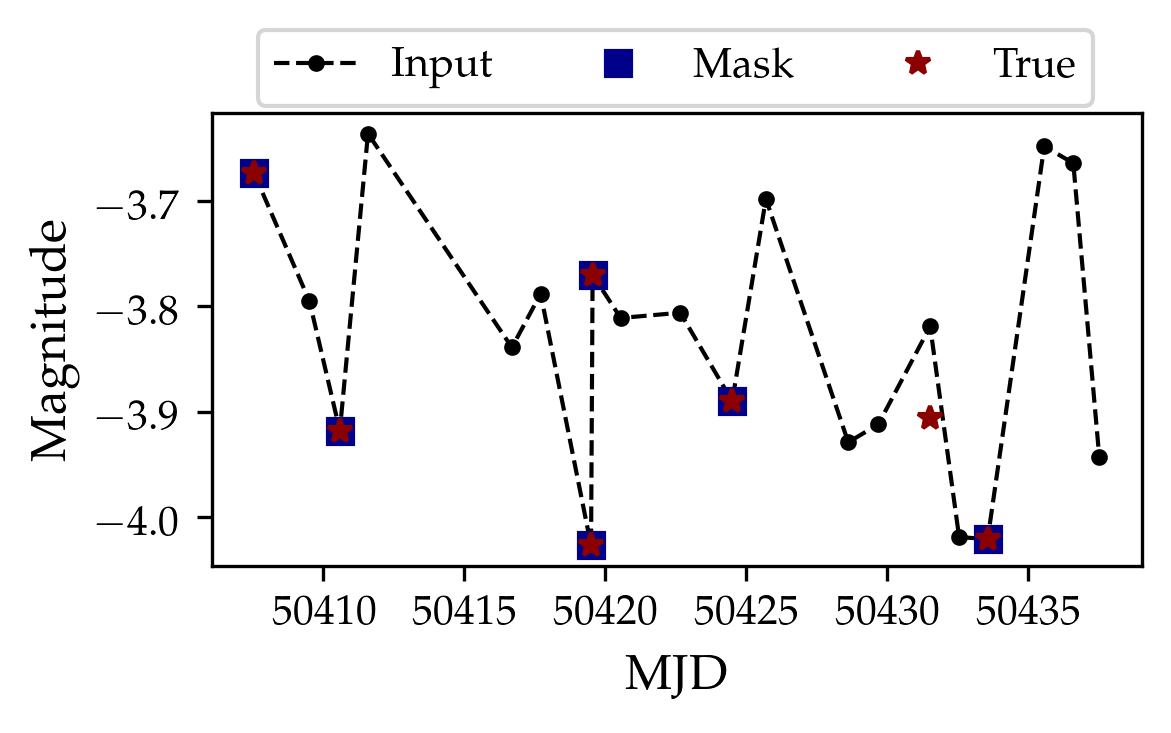

In [80]:
fig, axes = plt.subplots(1, 1, figsize=(4,2), sharex=True, sharey=True, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
lim = 20
start = 0
oid = 'F_1.4175.3433'.encode("utf-8")
for i, batch in enumerate(dataset):
    if oid in batch['id']:
        x_input  = batch['input'][batch['id'] == oid][-1][start:start+lim]
        x_output = batch['output'][batch['id'] == oid][-1][start:start+lim]
        t_sample = batch['times'][batch['id'] == oid][-1][start:start+lim]

        mask_in  = tf.squeeze(batch['mask_in'][batch['id'] == oid][-1][start:start+lim])
        mask_out = tf.squeeze(batch['mask_out'][batch['id'] == oid][-1][start:start+lim])


        times_masked = tf.boolean_mask(t_sample, mask_in)
        serie_masked = tf.boolean_mask(x_input, mask_in)


        times_masked_out = tf.boolean_mask(t_sample, mask_out)
        serie_masked_out = tf.boolean_mask(x_input, mask_out)

        axes.plot(t_sample, x_output, color='k', linestyle='--', marker='.', label='Input', linewidth=1)
        axes.plot(times_masked, serie_masked, marker='s', linestyle='', color='darkblue', label='Mask', linewidth=1)
        axes.plot(times_masked_out, serie_masked_out, color='darkred', linestyle='', marker='*', label='True', linewidth=1)

        axes.set_xlabel('MJD', fontsize=12)
        axes.set_ylabel('Magnitude', fontsize=12)    
        axes.legend(ncol=3, bbox_to_anchor=(0.97, 1.23))
        break
# fig.savefig('presentation/figures/input.png', transparent=True)
# fig.savefig('presentation/figures/input.pdf', format='pdf', bbox_inches='tight')

In [71]:
fig.savefig('./presentation/figures/input.pdf', format='pdf', bbox_inches='tight')

# Classification input 

In [1]:
cd ../..

/home/users/cdonoso/astromer/ASTROMER


In [12]:
import tensorflow as tf 
import os, sys
import matplotlib.pyplot as plt
from core.data import balanced_records

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
df_labels = pd.read_csv('./data/records/naul_macho/fold_0/naul_macho/objects.csv')
class_names = df_labels['label'].values
n_classes = len(class_names)
df_labels

,label,size
0,Ceph 1st,556
1,Ceph Fund,964
2,EB,5389
3,LPV WoodA,255
4,LPV WoodB,658
5,LPV WoodC,888
6,LPV WoodD,630
7,RRL + GB,185
8,RRL AB,5976
9,RRL C,1420


In [48]:
dataset = balanced_records('./data/records/ogle/fold_0/ogle/train/', 256, n_classes=n_classes, max_obs=200)

In [49]:
for batch, y in dataset:
    print(batch.keys())
    break

dict_keys(['input', 'times', 'mask_in'])


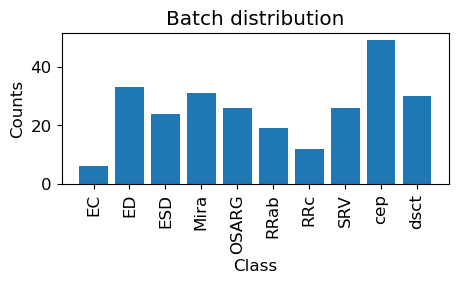

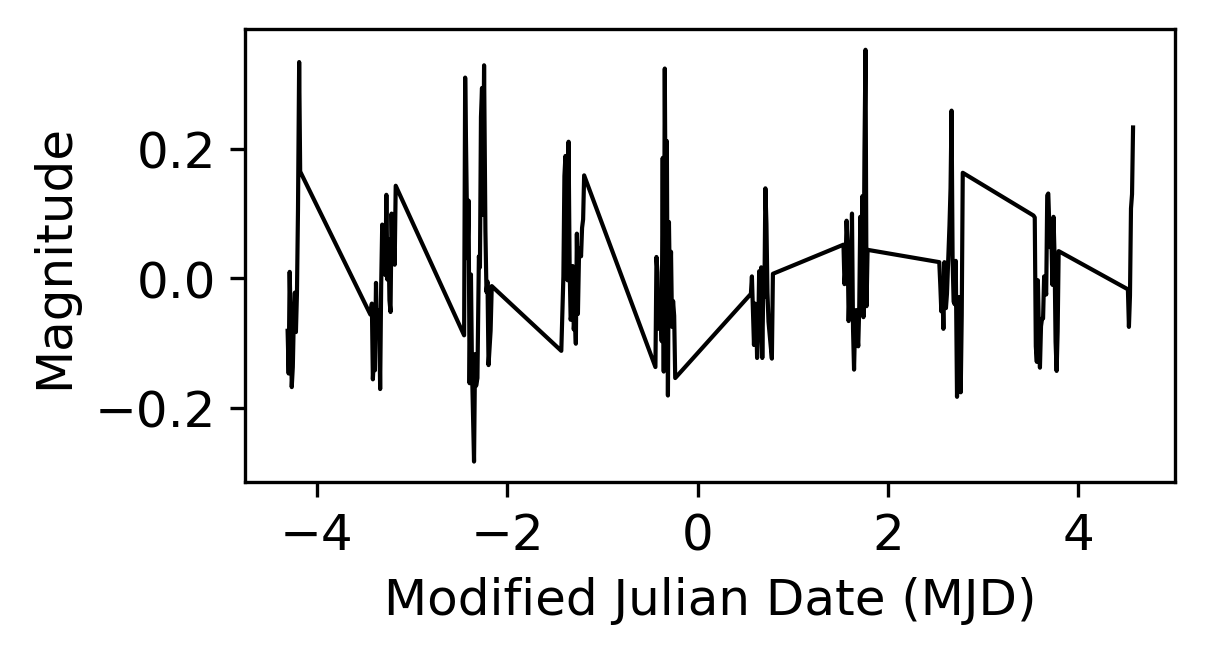

In [57]:
plt.rcParams.update({'font.size': 12})
for batch, y in dataset:
    y_label  = y[-1]
    x_input  = batch['input'][-1]
    t_sample = batch['times'][-1]
    
    mask_in  = tf.squeeze(batch['mask_in'][-1])

    times_masked = tf.boolean_mask(t_sample, mask_in)
    serie_masked = tf.boolean_mask(x_input, mask_in)
    
    # BATCH DISTRIBUTION
    plt.figure(figsize=(5,2), dpi=100)
    batch_labels = np.argmax(y.numpy(), 1)
    uniques, counts = np.unique(batch_labels, return_counts=True)
    x = range(len(uniques))
    plt.bar(x, counts)
    plt.xticks(x, class_names[:len(uniques)], rotation=90)
    plt.title('Batch distribution')
    plt.xlabel('Class')
    plt.ylabel('Counts')
    plt.show()
    
    # Lightcurve
    fig, axes = plt.subplots(1, 1, figsize=(4,2), sharex=True, sharey=True, 
                             gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
    axes.plot(t_sample, x_input, color='k', linestyle='-', marker='', label='Input', linewidth=1)
#     axes.set_title('{}'.format(str(class_names[y_label])))
    axes.set_xlabel('Modified Julian Date (MJD)')
    axes.set_ylabel('Magnitude')   
#     fig.savefig('presentation/figures/raw_input.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    break